<a href="https://colab.research.google.com/github/crispitagorico/sigoptim/blob/main/mean_variance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classical mean variance optimisation

Let $P$ be a portfolio of assets $A_1,...,A_N$ with weights $\mathbf w = (w_1,...,w_N) \in \mathbb{R}^N$ and (random) returns $\mathbf r = (r_1,...,r_N) \in \mathbb{R}^N$. 

The portfolio total expected P&L is given by
$$\mathbf w^\top \mathbb E[\mathbf r] = \sum_{i=1}^N w_i \mathbb E[r_i].$$

Let $\Sigma = \mathbb E[(\mathbf r - \mathbb E[\mathbf r])(\mathbf r - \mathbb E[\mathbf r])^\top]$ be the covariance matrix of the returns.

The portfolio total risk is given by
$$\mathbf w^\top \Sigma \mathbf w = \sum_{i,j=1}^N w_i\Sigma_{i,j}w_j.$$

The mean-variance optimisation problem is formulated as follows
$$\min_{\mathbf w} \mathbf w^\top \Sigma \mathbf w \quad \text{ subject to } \ \mathbf w^\top \mathbb E[\mathbf r] = \mu, \quad \sum_{i=1}^Nw_i=1 \ \text{ and } \ 0 \leq w_i \leq 1,$$

where $\mu \in [0,\infty)$ is the expected P&L.

In [63]:
import numpy as np
import pandas as pd
import scipy 
import matplotlib.pyplot as plt
import iisignature
import sympy as sym
from sklearn.linear_model import LinearRegression

from hall_areas.free_lie_algebra import *

In [7]:
def mean_variance_optim(expected_returns, covariance_matrix_returns, expected_pnl):

    # initialise weights
    N = expected_returns.size
    w0 = np.ones(N)

    # objective
    objective = lambda w: np.matmul(w.T, np.matmul(covariance_matrix_returns, w))

    # constraints
    bnds = tuple(N*[(0., 1.)])
    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
            {'type': 'eq', 'fun': lambda w: np.matmul(w.T, expected_returns) - expected_pnl})

    # run optimisation
    optim = scipy.optimize.minimize(fun=objective, x0=w0, bounds=bnds, constraints=cons)

    # return optimal weights 
    return optim.x

In [61]:
# number of assets
N = 10

# stocks
df      = pd.read_csv('stocks.csv', index_col=0)
names   = df.columns[:N].to_list()
prices  = df.iloc[-40:, :N].to_numpy()
returns = np.diff(prices, axis=0)/prices[:-1, :]

# expected returns
expected_returns = np.mean(returns, axis=0)

# covariance matrix of returns
covariance_matrix_returns = np.cov(returns, rowvar=False)

# expected portfolio returns
expected_pnls = np.linspace(0.0, 0.01, 50)

# optimal weights for given expected returns
optimal_weights = [mean_variance_optim(expected_returns, covariance_matrix_returns, pnl) for pnl in expected_pnls]

# actual portfolio P&L
pnls = [np.matmul(w.T, expected_returns) for w in optimal_weights]

# portfolio risk
risks = [np.matmul(w.T, np.matmul(covariance_matrix_returns, w)) for w in optimal_weights]

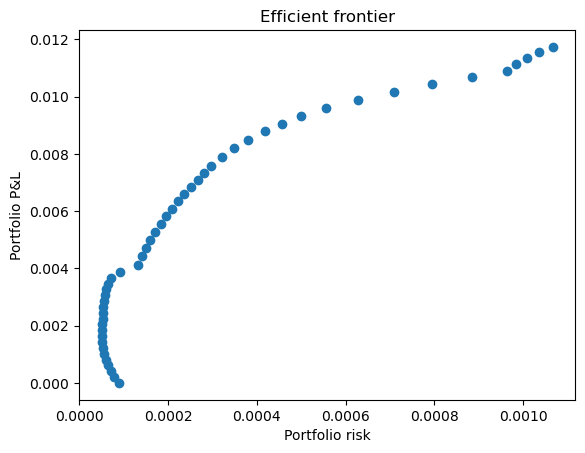

In [62]:
plt.scatter(risks, pnls)
plt.xlabel('Portfolio risk')
plt.ylabel('Portfolio P&L')
plt.title('Efficient frontier')
plt.show()

# Signature mean variance optimisation

Consider an $N$-dimensional price process $\mathbf S = (S^1,...,S^N) : [0,T] \to \mathbb{R}^N$. 

Consider $N$ linear functionals $\ell_i \in L(T^M(\mathbb{R}^N), \mathbb{R})$ for $i=1,...,N$ parameterised as

$$\ell_i = \sum_{|w| \leq M} \alpha^i_w w$$

Let $\ell = (\ell_1, ... ,\ell_N) \in L(T^M(\mathbb{R}^N), \mathbb{R}^N)$.

The expected P&L of a signature portfolio with weighting functional $\ell$ is given by

\begin{align}
\mathbb E \left[\int_0^T(\ell,S(X)_{0,t})^\top dX_t\right] &= \mathbb E \left[ \sum_{i=1}^N \int_0^T(\ell_i, S(X)_{0,t}) dX^i_t\right] \\
&= \mathbb E \left[ \sum_{i=1}^N \left(\ell_i \prec \mathbf i, S(X)_{0,T}\right)\right] \\
&= \sum_{i=1}^N \left(\ell_i \prec \mathbf i, \mathbb E \left[S(X)_{0,T}\right]\right)
\end{align}

where $\prec$ is the (right) half shuffle product (assuming paths start at $0$).

The portfolio total risk is given by

\begin{align}
& \mathbb E \left[\left(\int_0^T(\ell,S(X)_{0,t})^\top dX_t \right)^2\right] - \left(\mathbb E \left[\int_0^T(\ell,S(X)_{0,t})^\top dX_t \right]\right)^2\\
=& \ \mathbb E \left[ \sum_{i,j=1}^N \left(\ell_i \prec \mathbf i, S(X)_{0,T}\right)\left(\ell_j \prec \mathbf j, S(X)_{0,T}\right)\right] \\
& \quad - \sum_{i,j=1}^N  \left(\ell_i \prec \mathbf i, \mathbb E \left[S(X)_{0,T}\right]\right)\left(\ell_j \prec \mathbf j, \mathbb E \left[ S(X)_{0,T}\right]\right) \\
=&  \sum_{i,j=1}^N \left((\ell_i \prec \mathbf i) * (\ell_j \prec \mathbf j), \mathbb E \left[ S(X)_{0,T}\right]\right) -  \left(\ell_i \prec \mathbf i, \mathbb E \left[S(X)_{0,T}\right]\right)\left(\ell_j \prec \mathbf j, \mathbb E \left[ S(X)_{0,T}\right]\right)
\end{align}

where $*$ is the shuffle product.



The signature mean-variance optimisation problem is formulated as follows
$$\min_{\ell} \sum_{i,j=1}^N \left((\ell_i \prec \mathbf i) * (\ell_j \prec \mathbf j), \mathbb E \left[ S(X)_{0,T}\right]\right) -  \left(\ell_i \prec \mathbf i, \mathbb E \left[S(X)_{0,T}\right]\right)\left(\ell_j \prec \mathbf j, \mathbb E \left[ S(X)_{0,T}\right]\right)$$  

subject to 

$$\sum_{i=1}^N \left(\ell_i \prec \mathbf i, \mathbb E \left[S(X)_{0,T}\right]\right) = \mu$$

and need to find a way to formulate these constraints $\sum_{i=1}^Nw_i=1 \ \text{ and } \ 0 \leq w_i \leq 1$

where $\mu \in [0,\infty)$ is the expected P&L.

We need to understand

$$\frac{e^{\left(\ell_i, S(X)_{0,T}\right)}}{\sum_{j=1}^N e^{\left(\ell_j, S(X)_{0,T}\right)}}$$

Observe that 

\begin{align}
  e^{\left(\ell_i, S(X)_{0,T}\right)} &= \sum_{k=0}^\infty \frac{\left(\ell_i, S(X)_{0,T}\right)^k}{k!} \\
  &= \sum_{k=0}^\infty \frac{\left(\ell_i^{*k}, S(X)_{0,T}\right)}{k!} \\
  &= \left(\sum_{k=0}^\infty\frac{\ell_i^{*k}}{k!}, S(X)_{0,T}\right) \\
  &= \left(e^{\ell_i}, S(X)_{0,T}\right)
\end{align}

So we need to understand the rational function
$$\frac{\left(e^{\ell_i}, S(X)_{0,T}\right)}{\left(\sum_{j=1}^N e^{\ell_j}, S(X)_{0,T}\right)}$$

### 1. Required functions

We import all the tools required to build the signature mean-variance optimisation problem. This includes 

    1) Synthetic data generator (if required)
    2) Linear functional wrapper
    3) Expected signature wrapper
    4) Function to build the objective function.

In [ ]:
def make_linear_functional(coeffs, n_):
    linear_functional = 0.*word2Elt('')
    for i, w in enumerate(wordIter(2, n_)):
        linear_functional += coeffs[i]*word2Elt(w)
    return linear_functional